## **Step 1: Install Dependencies**
Before we start coding, install the necessary libraries.

In [1]:
pip install pandas numpy scikit-learn xgboost tensorflow matplotlib alpha_vantage

  Using cached xgboost-2.1.3-py3-none-win_amd64.whl.metadata (2.1 kB)
  Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
  Using cached alpha_vantage-3.0.0-py3-none-any.whl.metadata (12 kB)
  Using cached tensorflow_intel-2.18.0-cp312-cp312-win_amd64.whl.metadata (4.9 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.1.24-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached grpcio-1.70.0-cp312-cp312-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Usi

## **Step 2: Data Collection**
#### **Option 1: Fetch Data Using Alpha Vantage API**
- Create a free API key from Alpha Vantage.
- Fetch real-time EUR/USD, XAU/USD, USD/JPY forex data.
- 

In [14]:
import requests
import pandas as pd

API_KEY = ""  # Replace with your actual API Key

def fetch_daily_forex_data(symbol="EUR/USD"):
    base_url = "https://www.alphavantage.co/query"
    params = {
        "function": "FX_DAILY",
        "from_symbol": symbol.split("/")[0],
        "to_symbol": symbol.split("/")[1],
        "apikey": API_KEY,
        "outputsize": "full"
    }
    
    response = requests.get(base_url, params=params)
    data = response.json()

    # ✅ Check if the API response contains expected data
    key = "Time Series FX (Daily)"
    if key in data:
        df = pd.DataFrame.from_dict(data[key], orient="index")
        df = df.rename(columns={"1. open": "Open", "2. high": "High", "3. low": "Low", "4. close": "Close"})
        df.index = pd.to_datetime(df.index)  # Convert index to DateTime format
        df = df.astype(float)  # Convert to float
        df = df.sort_index(ascending=True)  # Sort by date (oldest to newest)
        return df
    else:
        print("Error: API did not return expected data.")
        return None

# ✅ Fetch Daily Forex Data
forex_data = fetch_daily_forex_data(symbol="EUR/USD")

# ✅ Print First 10 Rows of the Data
if forex_data is not None:
    print(forex_data.head(10))  # Displays first 10 rows
else:
    print("No data retrieved. Check API Key, rate limits, or try again later.")

               Open     High      Low    Close
2015-01-28  1.12848  1.13680  1.12641  1.12815
2015-01-29  1.13373  1.13640  1.12860  1.13356
2015-02-01  1.13047  1.13600  1.12929  1.13090
2015-02-02  1.13370  1.14500  1.13179  1.13417
2015-02-03  1.14569  1.14842  1.14042  1.14574
2015-02-04  1.13172  1.14600  1.13169  1.13187
2015-02-05  1.14709  1.14760  1.13200  1.14720
2015-02-08  1.13148  1.13600  1.12717  1.13144
2015-02-09  1.13261  1.13500  1.12756  1.13270
2015-02-10  1.13195  1.13320  1.12886  1.13220


## **Step 3: Feature Engineering**
In this step, we'll create technical indicators to enhance our model's ability to predict forex price movements.
#### **📌 Indicators to Add**
    - Moving Averages
1. SMA (Simple Moving Average): Average price over a fixed period.
2. EMA (Exponential Moving Average): Weighted moving average that reacts more to recent prices.
3. Relative Strength Index (RSI)
   - Helps identify overbought or oversold conditions.
4. MACD (Moving Average Convergence Divergence)
   - Measures the strength and direction of trends.
5. Bollinger Bands
   - Identifies price volatility and potential reversal points.

In [18]:
import pandas as pd

# Assuming forex_data is already loaded from Alpha Vantage API
# Make sure it contains 'Open', 'High', 'Low', 'Close'

def add_technical_indicators(df):
    # ✅ Simple Moving Average (SMA)
    df["SMA_10"] = df["Close"].rolling(window=10).mean()
    
    # ✅ Exponential Moving Average (EMA)
    df["EMA_10"] = df["Close"].ewm(span=10, adjust=False).mean()
    
    # ✅ Relative Strength Index (RSI)
    delta = df["Close"].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df["RSI"] = 100 - (100 / (1 + rs))

    # ✅ MACD Calculation
    short_ema = df["Close"].ewm(span=12, adjust=False).mean()
    long_ema = df["Close"].ewm(span=26, adjust=False).mean()
    df["MACD"] = short_ema - long_ema
    df["MACD_Signal"] = df["MACD"].ewm(span=9, adjust=False).mean()

    # ✅ Bollinger Bands
    df["BB_High"] = df["Close"].rolling(window=20).mean() + (df["Close"].rolling(window=20).std() * 2)
    df["BB_Low"] = df["Close"].rolling(window=20).mean() - (df["Close"].rolling(window=20).std() * 2)

    # ✅ Drop NaN values resulting from rolling calculations
    df.dropna(inplace=True)
    
    return df

# Apply technical indicators
forex_data = add_technical_indicators(forex_data)

# ✅ Display First 10 Rows
print(forex_data.head(10))

               Open     High      Low    Close    SMA_10    EMA_10        RSI  \
2015-02-24  1.13407  1.13880  1.13378  1.13390  1.136748  1.135952  51.496388   
2015-02-25  1.13627  1.13788  1.12027  1.13636  1.137264  1.136026  40.138282   
2015-02-26  1.12036  1.12500  1.11768  1.12054  1.135279  1.133210  40.094511   
2015-03-01  1.11709  1.12404  1.11640  1.11620  1.132899  1.130117  35.800344   
2015-03-02  1.11767  1.12140  1.11560  1.11790  1.131349  1.127896  37.942664   
2015-03-03  1.11841  1.11881  1.10628  1.11822  1.129124  1.126137  38.928693   
2015-03-04  1.10800  1.11089  1.10105  1.10821  1.125945  1.122877  22.930686   
2015-03-05  1.10340  1.10340  1.08522  1.10320  1.122598  1.119300  21.276928   
2015-03-08  1.08456  1.09100  1.08378  1.08460  1.117243  1.112991  17.920063   
2015-03-09  1.08358  1.08370  1.07059  1.08334  1.112247  1.107600   9.338078   

                MACD  MACD_Signal   BB_High    BB_Low  
2015-02-24  0.001475     0.001937  1.146001  1.12554

## **Step 4: Data Preprocessing**
Now that we have forex data with technical indicators, let's prepare it for machine learning by:

**✅ Normalizing Data:** Scaling values to a 0-1 range for better model performance.
**✅ Splitting Data:** Creating Training (80%) and Testing (20%) Sets.
**✅ Creating Sequences (for LSTM):** Converting data into a time-series format.

In [24]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Select Features (Technical Indicators)
features = ["Open", "High", "Low", "Close", "SMA_10", "EMA_10", "RSI", "MACD", "MACD_Signal", "BB_High", "BB_Low"]
target = "Close"

# ✅ Normalize Data
scaler = MinMaxScaler()
forex_data[features] = scaler.fit_transform(forex_data[features])

# ✅ Split Data (80% Train, 20% Test)
train_size = int(len(forex_data) * 0.8)
train_data, test_data = forex_data.iloc[:train_size], forex_data.iloc[train_size:]

X_train, X_test, y_train, y_test = train_data[features], test_data[features], train_data[target], test_data[target]

# ✅ Convert Data into Sequences for LSTM
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i : i + seq_length].values)
        y.append(data.iloc[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Lookback period
X_train_seq, y_train_seq = create_sequences(X_train, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test, seq_length)

# ✅ Reshape for LSTM
X_train_seq = X_train_seq.reshape(X_train_seq.shape[0], X_train_seq.shape[1], X_train_seq.shape[2])
X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1], X_test_seq.shape[2])

print(f"Training Data Shape: {X_train_seq.shape}, Testing Data Shape: {X_test_seq.shape}")

Training Data Shape: (2060, 10, 11), Testing Data Shape: (508, 10, 11)


## **Step 5: Train the XGBoost Model**
We'll first train an XGBoost model to predict the next closing price based on technical indicators.

In [27]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# ✅ Train XGBoost Model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=1000, learning_rate=0.05)
xgb_model.fit(X_train, y_train)

# ✅ Make Predictions
xgb_predictions = xgb_model.predict(X_test)

# ✅ Evaluate Model
mse_xgb = mean_squared_error(y_test, xgb_predictions)
print(f"XGBoost Model Mean Squared Error: {mse_xgb}")

XGBoost Model Mean Squared Error: 3.260936932352394e-06


## **Step 6: Visualize XGBoost Predictions vs. Actual Prices**
Now, let's plot the predicted vs. actual closing prices to evaluate the model visually.

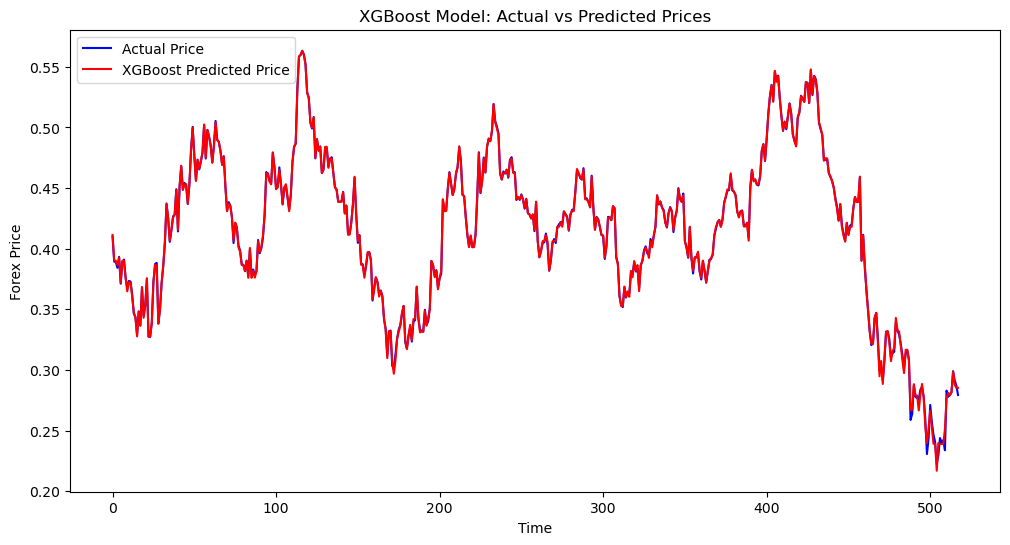

In [30]:
import matplotlib.pyplot as plt

# ✅ Plot Actual vs Predicted Prices
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual Price", color="blue")
plt.plot(xgb_predictions, label="XGBoost Predicted Price", color="red")
plt.xlabel("Time")
plt.ylabel("Forex Price")
plt.title("XGBoost Model: Actual vs Predicted Prices")
plt.legend()
plt.show()

## **Step 7: Train the LSTM Model**
Now, we can train a Long Short-Term Memory (LSTM) model to handle sequential data and potentially improve predictions.

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# ✅ Build the LSTM Model
lstm_model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Output layer for regression
])

lstm_model.compile(optimizer="adam", loss="mean_squared_error")

# ✅ Train the LSTM Model
history = lstm_model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, validation_data=(X_test_seq, y_test_seq))

# ✅ Make Predictions
lstm_predictions = lstm_model.predict(X_test_seq)

# ✅ Evaluate LSTM Model
mse_lstm = mean_squared_error(y_test_seq, lstm_predictions)
print(f"LSTM Model Mean Squared Error: {mse_lstm}")

Epoch 1/20


C:\Users\deeep\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 0.0400 - val_loss: 0.0010
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0042 - val_loss: 9.5200e-04
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0036 - val_loss: 7.3636e-04
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0033 - val_loss: 5.3239e-04
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0028 - val_loss: 6.3269e-04
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0026 - val_loss: 6.9484e-04
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0025 - val_loss: 4.5161e-04
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0027 - val_loss: 4.8363e-04
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0022 - val_loss: 4.4453e-04
Epoch 12/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [35]:
# Fix Sequence Creation Function
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i : i + seq_length].values)  # Features
        y.append(data.iloc[i + seq_length]["Close"])  # Target (Close price)
    return np.array(X), np.array(y)

# Recreate Sequences
X_train_seq, y_train_seq = create_sequences(X_train, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test, seq_length)

# Verify Shapes
print(f"X_train_seq shape: {X_train_seq.shape}, y_train_seq shape: {y_train_seq.shape}")
print(f"X_test_seq shape: {X_test_seq.shape}, y_test_seq shape: {y_test_seq.shape}")

X_train_seq shape: (2060, 10, 11), y_train_seq shape: (2060,)
X_test_seq shape: (508, 10, 11), y_test_seq shape: (508,)


## **Step 7: Visualize LSTM Predictions**
Let's plot the actual vs. predicted prices to see how well the LSTM model performs.

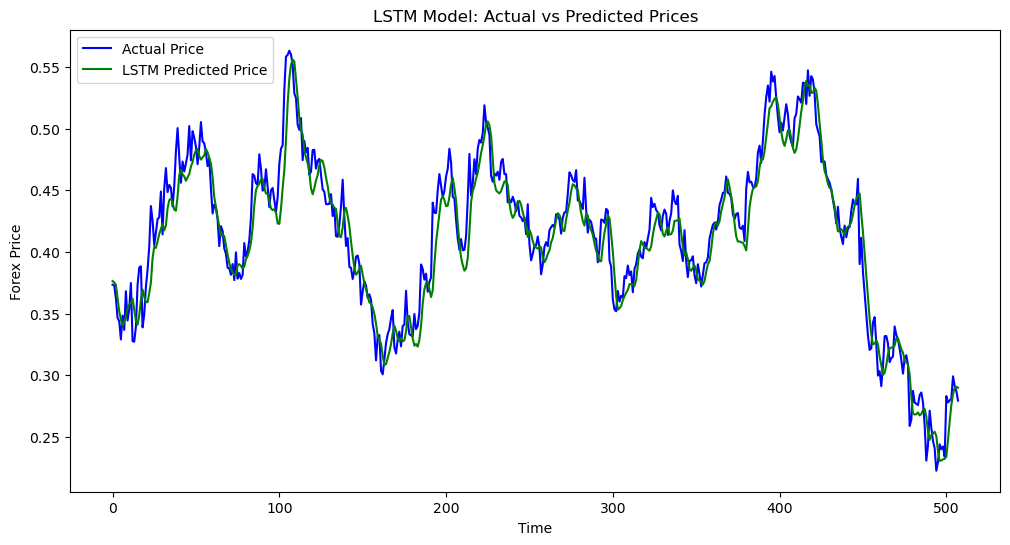

In [40]:
import matplotlib.pyplot as plt

# Plot LSTM Predictions vs Actual Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label="Actual Price", color="blue")
plt.plot(lstm_predictions, label="LSTM Predicted Price", color="green")
plt.xlabel("Time")
plt.ylabel("Forex Price")
plt.title("LSTM Model: Actual vs Predicted Prices")
plt.legend()
plt.show()

## **Step 8: Adding Buy/Sell Signals**
To make the model actionable for trading, let's add buy/sell signals based on the predicted prices. This step will help identify profitable trading opportunities.

- Strategy for Signals
- **Buy Signal:**
Triggered when the predicted price is expected to rise (uptrend).
Condition: Predicted Price (t) > Predicted Price (t-1)

- **Sell Signal:**
Triggered when the predicted price is expected to fall (downtrend).
Condition: Predicted Price (t) < Predicted Price (t-1)

In [44]:
# Add Buy/Sell Signals Based on LSTM Predictions
signals = []
for i in range(1, len(lstm_predictions)):
    if lstm_predictions[i] > lstm_predictions[i - 1]:
        signals.append("Buy")  # Uptrend
    else:
        signals.append("Sell")  # Downtrend

# Align with the dataset length
signals.insert(0, "Hold")  # First value has no prior data for comparison

# Add Signals to the Test Data
test_data = test_data.iloc[seq_length:]  # Match test_data with predictions
test_data["Actual Price"] = y_test_seq
test_data["Predicted Price"] = lstm_predictions
test_data["Signal"] = signals

# Display Results
print(test_data[["Actual Price", "Predicted Price", "Signal"]].head(10))

            Actual Price  Predicted Price Signal
2023-02-19      0.373464         0.376409   Hold
2023-02-20      0.372846         0.375293   Sell
2023-02-21      0.362345         0.373384   Sell
2023-02-22      0.346489         0.362409   Sell
2023-02-23      0.343847         0.351866   Sell
2023-02-26      0.328986         0.345132   Sell
2023-02-27      0.348342         0.340044   Sell
2023-02-28      0.336708         0.343752    Buy
2023-03-01      0.368145         0.346944    Buy
2023-03-02      0.344396         0.354506    Buy


## **Step 9: Visualize Signals**
Plot the buy/sell signals on the price chart for better visualization.

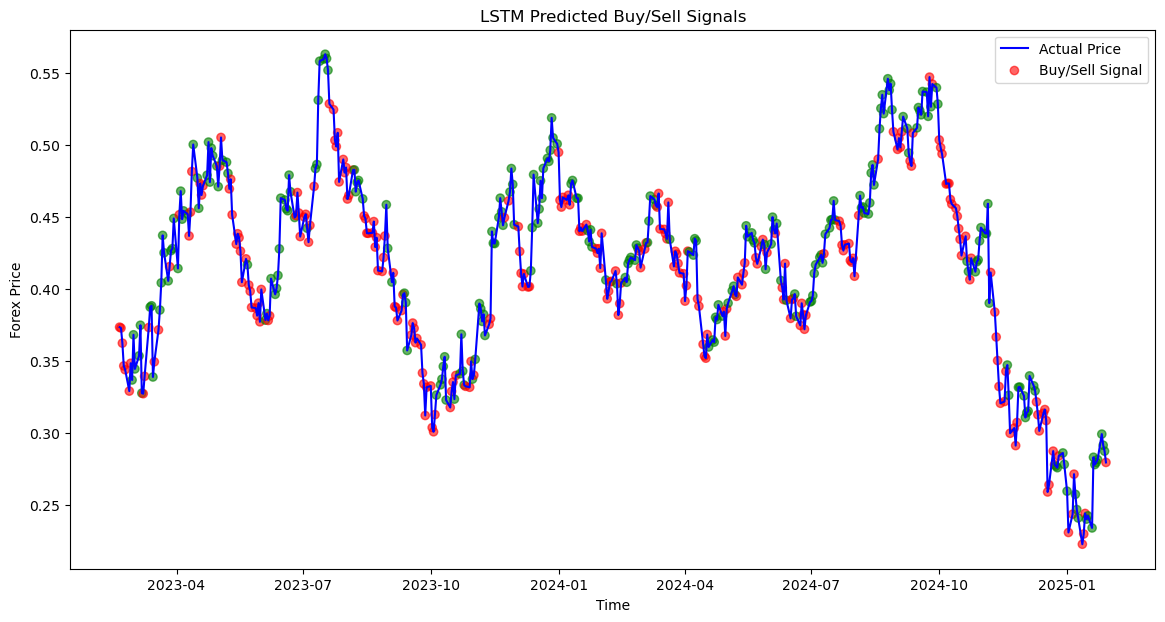

In [47]:
# Plot Actual Prices with Buy/Sell Signals
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_data["Actual Price"], label="Actual Price", color="blue")
plt.scatter(test_data.index, test_data["Actual Price"], c=["green" if s == "Buy" else "red" for s in test_data["Signal"]], label="Buy/Sell Signal", alpha=0.6)
plt.xlabel("Time")
plt.ylabel("Forex Price")
plt.title("LSTM Predicted Buy/Sell Signals")
plt.legend()
plt.show()

## **Step 10: Backtest the Strategy (Profit/Loss Simulation)**
Now, let’s evaluate how profitable the strategy would have been by calculating the cumulative returns based on these buy/sell signals.

In [50]:
# Backtest the Strategy
initial_balance = 10000  # Starting capital in USD
balance = initial_balance
position = 0  # Tracks if a position is held (1 for Buy, 0 for no position)

for i in range(len(test_data) - 1):
    if test_data["Signal"].iloc[i] == "Buy" and position == 0:  # Buy action
        position = balance / test_data["Actual Price"].iloc[i]  # Buy with all balance
        balance = 0
    elif test_data["Signal"].iloc[i] == "Sell" and position > 0:  # Sell action
        balance = position * test_data["Actual Price"].iloc[i]  # Sell all
        position = 0

# Final balance after backtesting
if position > 0:
    balance = position * test_data["Actual Price"].iloc[-1]  # Sell remaining position

profit = balance - initial_balance
print(f"Initial Balance: ${initial_balance:.2f}")
print(f"Final Balance: ${balance:.2f}")
print(f"Profit/Loss: ${profit:.2f}")

Initial Balance: $10000.00
Final Balance: $4946.62
Profit/Loss: $-5053.38


## **Step 11: Visualize Backtesting Results**
To better understand the returns over time, we can calculate the cumulative returns and plot them.

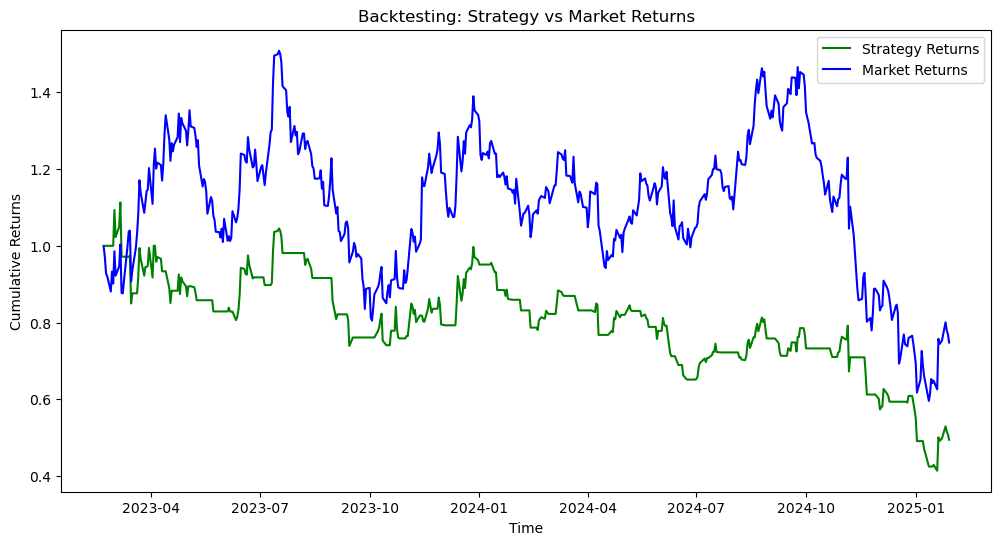

In [53]:
# Calculate Cumulative Returns
test_data["Returns"] = test_data["Actual Price"].pct_change()  # Daily returns
test_data["Strategy Returns"] = test_data["Returns"] * (test_data["Signal"] == "Buy").shift(1)  # Strategy returns
test_data["Cumulative Strategy Returns"] = (1 + test_data["Strategy Returns"]).cumprod()
test_data["Cumulative Market Returns"] = (1 + test_data["Returns"]).cumprod()

# Plot Cumulative Returns
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data["Cumulative Strategy Returns"], label="Strategy Returns", color="green")
plt.plot(test_data.index, test_data["Cumulative Market Returns"], label="Market Returns", color="blue")
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.title("Backtesting: Strategy vs Market Returns")
plt.legend()
plt.show()

In [55]:
# Add confidence threshold for Buy/Sell Signals
confidence_threshold = 0.01  # Example: Minimum price change of 1%
signals = []
for i in range(1, len(lstm_predictions)):
    price_change = (lstm_predictions[i] - lstm_predictions[i - 1]) / lstm_predictions[i - 1]
    if price_change > confidence_threshold:
        signals.append("Buy")
    elif price_change < -confidence_threshold:
        signals.append("Sell")
    else:
        signals.append("Hold")

# Align signals with test data
signals.insert(0, "Hold")  # First row has no prior data
test_data["Signal"] = signals

In [57]:
# Set Stop-Loss and Take-Profit Levels
stop_loss = 0.02  # 2% loss
take_profit = 0.04  # 4% profit

balance = initial_balance
position = 0
entry_price = 0

for i in range(len(test_data) - 1):
    current_price = test_data["Actual Price"].iloc[i]
    
    # Buy Signal
    if test_data["Signal"].iloc[i] == "Buy" and position == 0:
        position = balance / current_price
        entry_price = current_price
        balance = 0

    # Sell Signal or Stop-Loss/Take-Profit Condition
    elif position > 0:
        price_change = (current_price - entry_price) / entry_price
        if test_data["Signal"].iloc[i] == "Sell" or price_change >= take_profit or price_change <= -stop_loss:
            balance = position * current_price
            position = 0

# Final balance
if position > 0:
    balance = position * test_data["Actual Price"].iloc[-1]

profit = balance - initial_balance
print(f"Final Balance with Stop-Loss/Take-Profit: ${balance:.2f}")
print(f"Profit/Loss: ${profit:.2f}")


Final Balance with Stop-Loss/Take-Profit: $11068.32
Profit/Loss: $1068.32


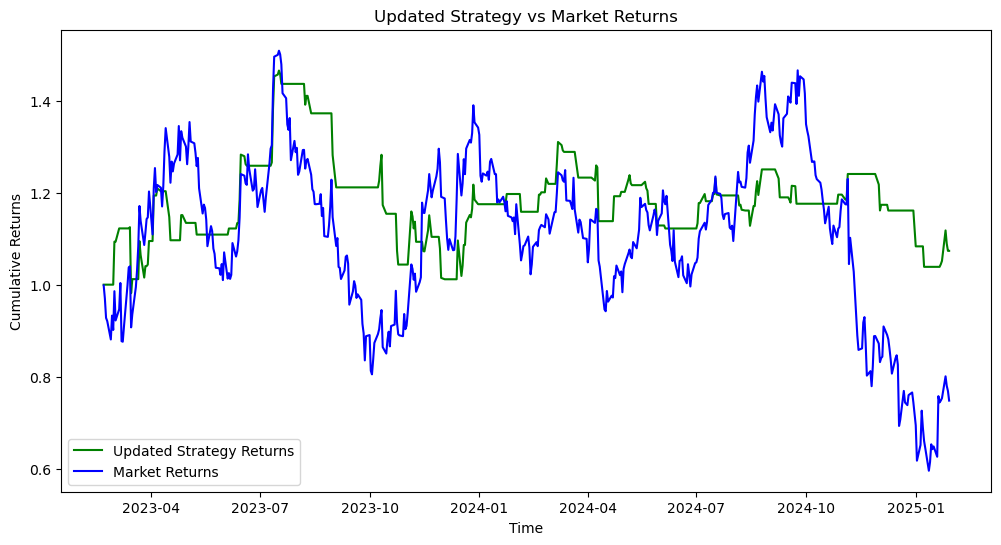

In [59]:
# Updated Cumulative Returns
test_data["Strategy Returns"] = test_data["Returns"] * (test_data["Signal"] == "Buy").shift(1)  # Updated strategy
test_data["Cumulative Strategy Returns"] = (1 + test_data["Strategy Returns"]).cumprod()

# Plot Updated Cumulative Returns
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data["Cumulative Strategy Returns"], label="Updated Strategy Returns", color="green")
plt.plot(test_data.index, test_data["Cumulative Market Returns"], label="Market Returns", color="blue")
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.title("Updated Strategy vs Market Returns")
plt.legend()
plt.show()